# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

import tensorflow as tf

import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import pandas as pd
import re
import os

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, model_from_json, Model

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, LeakyReLU, Activation
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, SeparableConv2D
from keras.layers import Input, ZeroPadding2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
import keras.backend as K
K.set_image_data_format('channels_last')
from keras.optimizers import Adam
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight

from sklearn.metrics import roc_curve, roc_auc_score

RSEED = 3    # Vamos usar a mesma seed para tudo

# 1. Unbalanced vs Balanced vs Balanced + Finnetunning

In [2]:
n_epochs = 25       # nº de epochs
n_steps = 200       # steps por epoch
image_size = 180    # tamanho na imagem para o qual vamos normalizar -> [180,180]

**1.1. Visualizar a data**

1.1.1 Dar import as imagens de treino e test e obter o set de validação

Vai ser usado um split de 80:20 entre treino e validação

In [3]:
# Imagens de TREINO e VALIDAÇÃO
files_train = tf.io.gfile.glob('chest_xray/train/*/*')

# Fazer a divisão dos ficheiros de treino em 80% para treino e 20% para teste
train_imgs, val_imgs = train_test_split(files_train, test_size=0.2, random_state=RSEED)

# Imagens de TESTE
test_imgs = tf.io.gfile.glob('chest_xray/test/*/*')

1.1.2 Contar a quantidade de casos (Pneumonia ou Normal) em cada set

In [4]:
norm_IMG_Train = 0
arry_hist_train = []

for img in train_imgs:
    if "NORMAL" in img:
        norm_IMG_Train = norm_IMG_Train + 1
        arry_hist_train.append(0)

print("Normal images in the Training Set: ", norm_IMG_Train)


pneu_IMG_Train = 0

for img in train_imgs:
    if "PNEUMONIA" in img:
        pneu_IMG_Train = pneu_IMG_Train + 1
        arry_hist_train.append(1)

print("Pneumonia images in the Training Set: ", pneu_IMG_Train)

total_img_Train = norm_IMG_Train + pneu_IMG_Train
print("Total images in Training Set: ", total_img_Train)

#-----------------------------
print(' ')
#-----------------------------


# Fazer a contagem de imagens de Validação


norm_IMG_Val = 0
arry_hist_val = []

for img in val_imgs:
    if "NORMAL" in img:
        norm_IMG_Val = norm_IMG_Val + 1
        arry_hist_val.append(0)

print("Normal images in the Validation Set: ", norm_IMG_Val)


pneu_IMG_Val = 0

for img in val_imgs:
    if "PNEUMONIA" in img:
        pneu_IMG_Val = pneu_IMG_Val + 1
        arry_hist_val.append(1)

print("Pneumonia images in the Validation Set: ", pneu_IMG_Val)

total_img_Val = norm_IMG_Val + pneu_IMG_Val
print("Total images in Validation Set: ", total_img_Val)

#-----------------------------
print(' ')
#-----------------------------


# Fazer a contagem de imagens de Teste


norm_IMG_Test = 0
arry_hist_test = []

for img in test_imgs:
    if "NORMAL" in img:
        norm_IMG_Test = norm_IMG_Test + 1
        arry_hist_test.append(0)

print("Normal images in the Testing Set: ", norm_IMG_Test)


pneu_IMG_Test = 0

for img in test_imgs:
    if "PNEUMONIA" in img:
        pneu_IMG_Test = pneu_IMG_Test + 1
        arry_hist_test.append(1)

print("Pneumonia images in the Testing Set: ", pneu_IMG_Test)

total_img_Test = norm_IMG_Test + pneu_IMG_Test
print("Total images in Testing Set: ", total_img_Test)

Normal images in the Training Set:  1072
Pneumonia images in the Training Set:  3113
Total images in Training Set:  4185
 
Normal images in the Validation Set:  277
Pneumonia images in the Validation Set:  770
Total images in Validation Set:  1047
 
Normal images in the Testing Set:  234
Pneumonia images in the Testing Set:  390
Total images in Testing Set:  624


Podemos ver que existem mais casos de Pneumonia do que Normal, o que indica que a data está unbalanced. Vamos vizualizar os Histogramas

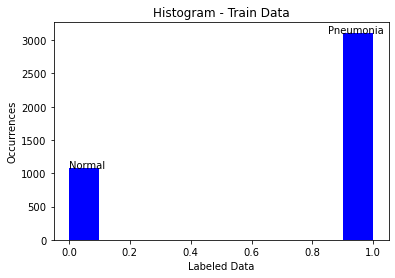

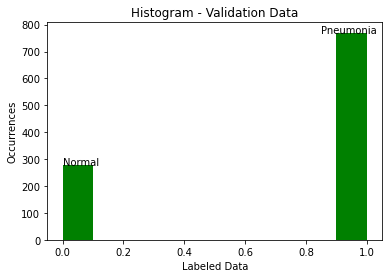

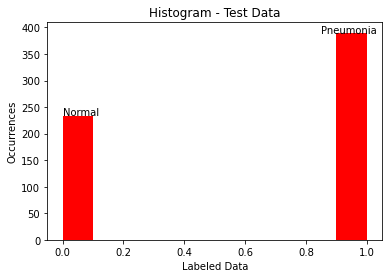

In [5]:
# Plotar histogramas
plt.hist(arry_hist_train, color = "blue")
plt.ylabel("Occurrences")
plt.xlabel("Labeled Data")
plt.title("Histogram - Train Data")
plt.annotate("Normal", (0, norm_IMG_Train))
plt.annotate("Pneumonia", (0.85, pneu_IMG_Train))
plt.show()

plt.hist(arry_hist_val, color = "green")
plt.ylabel("Occurrences")
plt.xlabel("Labeled Data")
plt.title("Histogram - Validation Data")
plt.annotate("Normal", (0, norm_IMG_Val))
plt.annotate("Pneumonia", (0.85, pneu_IMG_Val))
plt.show()

plt.hist(arry_hist_test, color = "red")
plt.ylabel("Occurrences")
plt.xlabel("Labeled Data")
plt.title("Histogram - Test Data")
plt.annotate("Normal", (0, norm_IMG_Test))
plt.annotate("Pneumonia", (0.85, pneu_IMG_Test))
plt.show()

**1.3 Data Setup**

In [6]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 180
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #read black and white
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
def get_train(indx):

    data = get_data('C:\\Users\\OMEN\\OneDrive - Universidade de Aveiro\\Mestrado\\4 ano\\1 semestre\\AIA\\Projeto 1\\chest_xray\\train')

    l = []
    for i in data:
        if(i[1] == 0):
            l.append(labels[0])
        else:
            l.append(labels[1])

    if indx == 1:
        sns.set_style('darkgrid')
        sns.countplot(l)

        plt.figure(figsize = (5,5))
        plt.imshow(data[1][0])
        plt.title(labels[data[0][1]])

        plt.figure(figsize = (5,5))
        plt.imshow(data[-1][0])
        plt.title(labels[data[-1][1]])

    x = []
    y = []

    for feature, label in data:
        x.append(feature)
        y.append(label)

    x = np.array(x) / image_size
    y = np.array(y).reshape((-1,1))

    return x,y

In [8]:
def get_test(indx):

    data = get_data('C:\\Users\\OMEN\\OneDrive - Universidade de Aveiro\\Mestrado\\4 ano\\1 semestre\\AIA\\Projeto 1\\chest_xray\\test')
    
    l = []
    for i in data:
        if(i[1] == 0):
            l.append(labels[0])
        else:
            l.append(labels[1])

    if indx == 1:
        sns.set_style('darkgrid')
        sns.countplot(l)

        plt.figure(figsize = (5,5))
        plt.imshow(data[1][0])
        plt.title(labels[data[0][1]])

        plt.figure(figsize = (5,5))
        plt.imshow(data[-1][0])
        plt.title(labels[data[-1][1]])

    x = []
    y = []

    for feature, label in data:
        x.append(feature)
        y.append(label)

    x = np.array(x) / image_size
    y = np.array(y).reshape((-1,1))

    return x,y

In [9]:
x,y = get_train(0)

print(x.shape)
print(y.shape)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9992\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(5232, 180, 180, 3)
(5232, 1)


In [10]:
x_test,y_test = get_train(0)

print(x_test.shape)
print(y_test.shape)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9992\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(5232, 180, 180, 3)
(5232, 1)


**1.5 Data Split**

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RSEED)

**1.6 Calcular os pesos para balancear a data**

In [12]:
weight_for_0 = (1 / norm_IMG_Train)*(total_img_Train)/2.0 
weight_for_1 = (1 / pneu_IMG_Train)*(total_img_Train)/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


**1.7 Construir o Modelo CNN**

Inspiração : https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8

In [13]:
inputs = Input(shape=(180, 180, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Unbalanced

**UB.1 Compilar o modelo**

Como o training set e o test set estão unbalanced, vamos apenas olhar para Precision e Recall

Vamos assumir um learning rate de 0.000001 (quanto mais pequeno mais 'smooth' é a curva, mas mais tempo demora a convergir)

In [14]:
METRICS = [
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]


opt = Adam(learning_rate=0.000001)

# Creating model and compiling
modelUN = Model(inputs=inputs, outputs=output)
modelUN.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
modelUN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 90, 90, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 90, 90, 32)       1344  

**UB.2 Guardar a history**

In [15]:
history = modelUN.fit(
    x_train, y_train,
    steps_per_epoch=n_steps,
    epochs=n_epochs,
    validation_data=(x_val, y_val),
)

Epoch 1/25
200/200 [==============================] - 107s 530ms/step - loss: 0.6929 - precision: 0.7693 - recall: 0.7273 - val_loss: 0.6927 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/25
200/200 [==============================] - 123s 613ms/step - loss: 0.6923 - precision: 0.7544 - recall: 0.9749 - val_loss: 0.6922 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/25
200/200 [==============================] - 123s 614ms/step - loss: 0.6917 - precision: 0.7458 - recall: 0.9936 - val_loss: 0.6914 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/25
200/200 [==============================] - 123s 616ms/step - loss: 0.6909 - precision: 0.7447 - recall: 0.9987 - val_loss: 0.6902 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/25
200/200 [==============================] - 123s 615ms/step - loss: 0.6900 - precision: 0.7443 - recall: 0.9984 - val_loss: 0.6888 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 6/25
200/200 [==============================] - 122s 609ms/step 

**UB.3 Visualizar os gráficos**

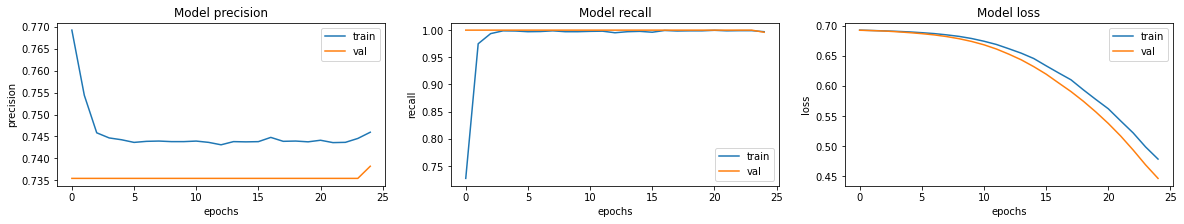

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    plt.savefig("unbalanced.png")

**UB.4 Calcular as metrics**

In [17]:
x_test,y_test = get_test(0)

print(x_test.shape)
print(y_test.shape)

loss, prec, rec = modelUN.evaluate(x_test,y_test)

F1 = 2 * (prec * rec) / (prec + rec)

print("Loss:",loss)
print("Precision: %.2f%%" % (prec*100))
print("Recall: %.2f%%" % (rec*100))
print("F1 Score: %.2f%%" % (F1*100))

ypred_UNbal = modelUN.predict(x_test)

ypred_val_UNbal = np.array([1 if x > 0.5 else 0 for x in ypred_UNbal])

print(confusion_matrix(y_test, ypred_val_UNbal))
print('\n',classification_report(ypred_val_UNbal,y_test))

#ROC
FPR_UN, TPR_UN, Threshold_UB = roc_curve(arry_hist_test, ypred_UNbal, pos_label=1)
#AUC
AUC_UN = roc_auc_score(arry_hist_test, ypred_UNbal)

print('AUC Score:',AUC_UN)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9992\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(624, 180, 180, 3)
(624, 1)
20/20 [==============================] - 2s 113ms/step - loss: 0.5367 - precision: 0.6270 - recall: 1.0000
Loss: 0.5366751551628113
Precision: 62.70%
Recall: 100.00%
F1 Score: 77.08%
20/20 [==============================] - 2s 98ms/step
[[  2 232]
 [  0 390]]

               precision    recall  f1-score   support

           0       0.01      1.00      0.02         2
           1       1.00      0.63      0.77       622

    accuracy                           0.63       624
   macro avg       0.50      0.81      0.39       624
weighted avg       1.00      0.63      0.77       624

AUC Score: 0.8915296953758491


# Balanced

**B.1 Compilar o modelo**

In [18]:
METRICS = [
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]


opt = Adam(learning_rate=0.000001)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

**B.2 Guardar a history**

In [19]:
history = model.fit(
    x_train, y_train,
    steps_per_epoch=n_steps,
    epochs=n_epochs,
    validation_data=(x_val, y_val),
    class_weight=class_weights,
)

Epoch 1/25
200/200 [==============================] - 67s 324ms/step - loss: 0.5955 - precision: 0.7551 - recall: 0.9945 - val_loss: 0.4820 - val_precision: 0.8583 - val_recall: 0.9364
Epoch 2/25
200/200 [==============================] - 70s 348ms/step - loss: 0.5737 - precision: 0.7772 - recall: 0.9859 - val_loss: 0.4737 - val_precision: 0.9179 - val_recall: 0.9000
Epoch 3/25
200/200 [==============================] - 74s 368ms/step - loss: 0.5572 - precision: 0.8089 - recall: 0.9711 - val_loss: 0.4503 - val_precision: 0.9200 - val_recall: 0.8961
Epoch 4/25
200/200 [==============================] - 73s 367ms/step - loss: 0.5466 - precision: 0.8403 - recall: 0.9566 - val_loss: 0.4257 - val_precision: 0.9124 - val_recall: 0.9065
Epoch 5/25
200/200 [==============================] - 72s 360ms/step - loss: 0.5360 - precision: 0.8579 - recall: 0.9425 - val_loss: 0.4138 - val_precision: 0.9221 - val_recall: 0.8922
Epoch 6/25
200/200 [==============================] - 74s 372ms/step - loss

**B.3 Visualizar os gráficos**

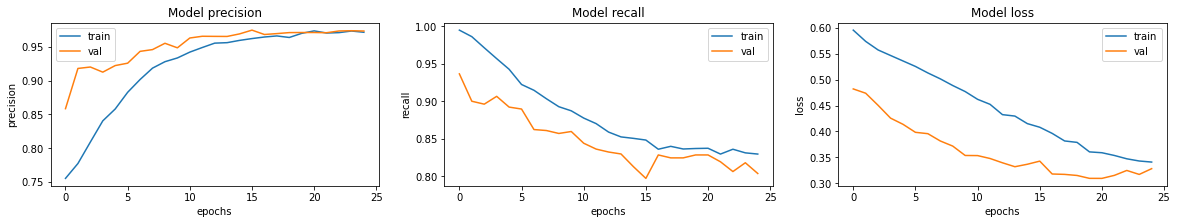

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    plt.savefig("balanced.png")

    

**B.4 Calcular as metrics**

In [21]:
x_test,y_test = get_test(0)

print(x_test.shape)
print(y_test.shape)

loss, prec, rec = model.evaluate(x_test,y_test)

F1 = 2 * (prec * rec) / (prec + rec)

print("Loss:",loss)
print("Precision: %.2f%%" % (prec*100))
print("Recall: %.2f%%" % (rec*100))
print("F1 Score: %.2f%%" % (F1*100))

ypred_bal = model.predict(x_test)

ypred_val_bal = np.array([1 if x > 0.5 else 0 for x in ypred_bal])

print(confusion_matrix(y_test, ypred_val_bal))
print('\n',classification_report(ypred_val_bal,y_test))

#ROC
FPR_B, TPR_B, Threshold_B = roc_curve(arry_hist_test, ypred_bal, pos_label=1)
#AUC
AUC_B = roc_auc_score(arry_hist_test, ypred_bal)

print('AUC Score:',AUC_B)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9992\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(624, 180, 180, 3)
(624, 1)
20/20 [==============================] - 3s 140ms/step - loss: 0.4054 - precision: 0.8747 - recall: 0.8410
Loss: 0.4054391384124756
Precision: 87.47%
Recall: 84.10%
F1 Score: 85.75%
20/20 [==============================] - 3s 131ms/step
[[187  47]
 [ 62 328]]

               precision    recall  f1-score   support

           0       0.80      0.75      0.77       249
           1       0.84      0.87      0.86       375

    accuracy                           0.83       624
   macro avg       0.82      0.81      0.82       624
weighted avg       0.82      0.83      0.82       624

AUC Score: 0.8945759368836292


# Gráficos ROC e valores de AUC

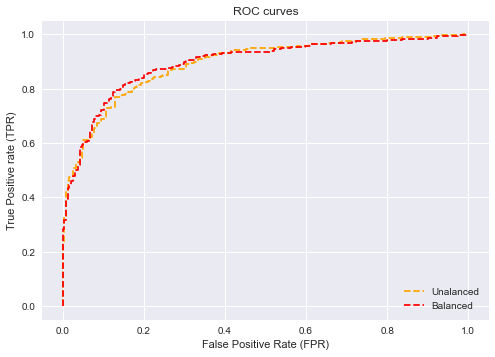

AUC Unbalanced: 0.8915
AUC Balanced: 0.8946


In [22]:
plt.style.use('seaborn')

plt.plot(FPR_UN, TPR_UN, linestyle='--',color='orange', label='Unalanced')
plt.plot(FPR_B, TPR_B, linestyle='--',color='red', label='Balanced')

plt.title('ROC curves')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive rate (TPR)')
plt.legend(loc='lower right')
plt.savefig("ROC.png")
plt.show()


print("AUC Unbalanced:", round(AUC_UN,4))
print("AUC Balanced:", round(AUC_B,4))

# Predict Images

**Unbalanced**

1/1 [==============================] - 0s 23ms/step
Normal


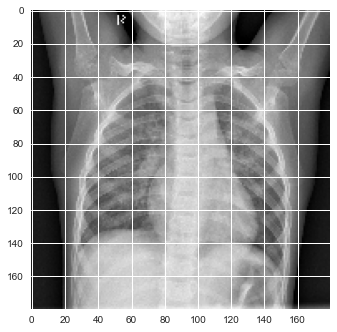

In [23]:
# Fazer predict de uma imagem

img_path = 'chest_xray/train/NORMAL/IM-0115-0001.jpeg'

img=tf.keras.utils.load_img(img_path, target_size=(180, 180))
imshow(img)

x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

if modelUN.predict(x) == 0:
    print('Normal')
else:
    print('Pneumonia')

**Balanced**

1/1 [==============================] - 0s 23ms/step
Normal


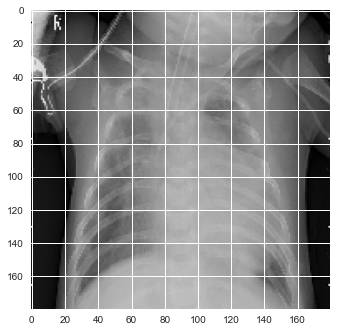

In [24]:
# Fazer predict de uma imagem

img_path = 'chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'

img=tf.keras.utils.load_img(img_path, target_size=(180, 180))
imshow(img)

x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

if model.predict(x) == 0:
    print('Normal')
else:
    print('Pneumonia')